<a href="https://colab.research.google.com/github/VivoSorhie/Sephora-Reviews-Sentiment-Analysis/blob/main/Sephora__Product_Risk_Mitigation_via_NLP_Sentiment_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Project Setup & Data Loading**
***
* **Import Libraries:** We will import all packages upfront, including `pandas`, `seaborn`, `nltk`, and `transformers`.
* **Load Data:** We will upload the `sephora_sample_data.csv` (which i have already cleaned from a prior dataset) file to our Colab environment and load it into a pandas DataFrame named `df_sample`, which will be our primary dataset for the entire project.

In [2]:
# Install required libraries silently
!pip install -q transformers datasets squarify

# --- 1.1: Import All Necessary Libraries ---
import pandas as pd
import numpy as np
import io
import os
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from google.colab import files

# Download NLTK data required for text cleaning
nltk.download('stopwords')

# Set a default style and size for all our plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("All libraries installed and imported successfully!")
print("-" * 50)


# --- 1.2: Upload and Load the Dataset ---
print("Please upload your 'sephora_sample_data.csv' file.")

# Prompt for file upload
uploaded = files.upload()

# Get the filename of the uploaded file and load it
file_name = next(iter(uploaded))

try:
    df_sample = pd.read_csv(io.StringIO(uploaded[file_name].decode('utf-8')))
    print(f"\nFile '{file_name}' uploaded and loaded successfully!")
    print(f"DataFrame 'df_sample' created with {df_sample.shape[0]} rows and {df_sample.shape[1]} columns.")

    # Display the first few rows and info to confirm it's correct
    print("\n--- DataFrame Info ---")
    df_sample.info()
    print("\n--- DataFrame Head ---")
    display(df_sample.head())

except Exception as e:
    print(f"An error occurred: {e}")

All libraries installed and imported successfully!
--------------------------------------------------
Please upload your 'sephora_sample_data.csv' file.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Saving sephora_sample_data.csv to sephora_sample_data.csv

File 'sephora_sample_data.csv' uploaded and loaded successfully!
DataFrame 'df_sample' created with 92323 rows and 15 columns.

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92323 entries, 0 to 92322
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   product_name      92323 non-null  object 
 1   brand_name        92323 non-null  object 
 2   primary_category  92323 non-null  object 
 3   review_title      66307 non-null  object 
 4   review_text       92323 non-null  object 
 5   rating_review     92323 non-null  int64  
 6   is_recommended    77670 non-null  float64
 7   helpfulness       44583 non-null  float64
 8   price_usd         92323 non-null  float64
 9   skin_type         82707 non-null  object 
 10  skin_tone         77651 non-null  object 
 11  eye_color         74239 non-null  object 
 12  hair_color        

,product_name,brand_name,primary_category,review_title,review_text,rating_review,is_recommended,helpfulness,price_usd,skin_type,skin_tone,eye_color,hair_color,sentiment,cleaned_review
0,Cicapair Tiger Grass Sleepair Intensive Mask,Dr. Jart+,Skincare,Very hydrating,I love how this feels on my face! It’s incredi...,5,1.0,NaN,42.0,combination,light,hazel,blonde,1,love feel face incredibly hydrating wake morni...
1,Clear Improvement Pore Clearing Moisturizer wi...,Origins,Skincare,Love,I love this product! it works so well for peop...,5,1.0,NaN,40.0,oily,fair,brown,blonde,1,love product work well people oilyacne prone s...
2,Rapid Dark Spot Correcting Serum,Murad,Skincare,great for reducing dark spots,"Great serum, visibly reduced my dark spots. Sp...",5,1.0,NaN,83.0,combination,fair,brown,black,1,great serum visibly reduced dark spot spread e...
3,Bye Bye Makeup 3-in-1 Makeup Melting Cleansing...,IT Cosmetics,Skincare,A great addition to my beauty routine,I love products that have multi-functions. Thi...,4,1.0,NaN,42.0,combination,fair,blue,blonde,1,love product multifunctions balm easily remove...
4,Pore-Balance Facial Sauna Scrub,OLEHENRIKSEN,Skincare,LOVE,This is really good in between type of scrub. ...,4,NaN,0.4,35.0,NaN,NaN,NaN,NaN,1,really good type scrub noticed overall differe...


# 2. **Data Cleaning and EDA**

### 2.1 Raw Rating Distribution
***
* **Objective:** Understand the overall landscape of customer feedback before feature engineering.
* **What We Do:** Visualize the distribution of the `rating_review` column to identify patterns, skewness, or class imbalance.
* **Why:** Provides a foundational understanding of the dataset and informs preprocessing and modeling decisions.
* We will not be using `3` as it is neutral

--- 2.1: Analyzing the distribution of raw star ratings ---


/tmp/ipython-input-1609652265.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='rating_review', data=df_sample, palette='viridis')


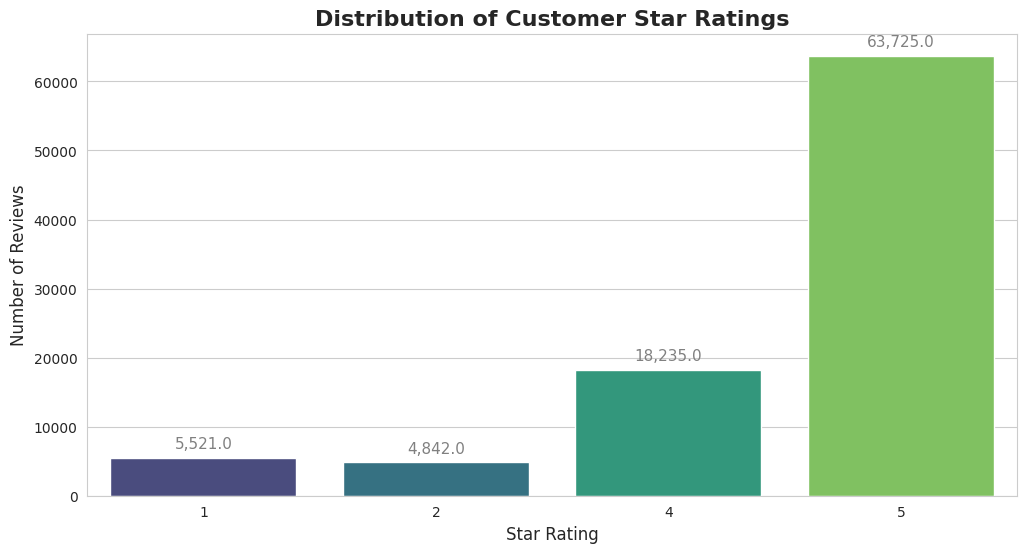

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 2.1: Analyze Raw Star Rating Distribution ---
print("--- 2.1: Analyzing the distribution of raw star ratings ---")

plt.figure(figsize=(12, 6))
ax = sns.countplot(x='rating_review', data=df_sample, palette='viridis')
plt.title('Distribution of Customer Star Ratings', fontsize=16, weight='bold')
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

# Add annotations to make the chart instantly readable
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                textcoords='offset points')
plt.show()

### Insights
***
* **Observation:** The distribution of ratings is strongly positively skewed. Most reviews are 5-star, while 1-2 star reviews are rare.
* **Implications:**
  - Customers are generally satisfied.
  - Significant **class imbalance** exists for sentiment modeling: negative class is much smaller than positive class.
* **Next Step:** Verify that the `sentiment` column correctly reflects business logic (1-2 stars = Negative, 4-5 stars = Positive) to ensure target variable integrity.
* **Why It Matters:** Class imbalance can bias the model toward the majority class, affecting metrics like accuracy, F1-score, and AUC. We will need to account for this during preprocessing and evaluation.


### 2.2 Verifying the Sentiment Column
***
* **Objective:** Ensure the `sentiment` column aligns with our business logic for binary classification (1-2 stars = Negative, 4-5 stars = Positive).
* **What We Do:** Check that the sentiment labels correctly reflect the rating values and calculate the proportion of positive vs negative reviews.
* **Why:** Confirms the integrity of our target variable and quantifies the **class imbalance** we need to address during modeling.
* **Next Step:** Based on this verification, decide on preprocessing strategies such as **resampling, class weighting, or stratified splitting** to handle imbalance effectively.


--- 2.2: Verifying the sentiment column distribution ---

Sentiment Class Distribution:
sentiment
1    81960
0    10363
Name: count, dtype: int64

Negative (0) reviews make up 11.22% of the dataset.
Positive (1) reviews make up 88.78% of the dataset.


/tmp/ipython-input-286379502.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')


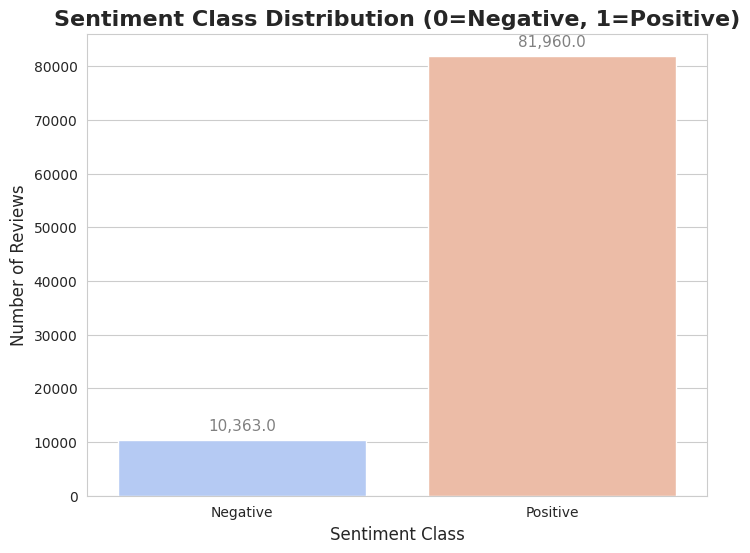

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 2.2: Verify and Quantify Sentiment Class Distribution ---
print("--- 2.2: Verifying the sentiment column distribution ---")

# Quantify the class imbalance in the 'sentiment' column
print("\nSentiment Class Distribution:")
sentiment_counts = df_sample['sentiment'].value_counts()
print(sentiment_counts)
print(f"\nNegative (0) reviews make up {sentiment_counts[0] / sentiment_counts.sum() * 100:.2f}% of the dataset.")
print(f"Positive (1) reviews make up {sentiment_counts[1] / sentiment_counts.sum() * 100:.2f}% of the dataset.")

# Visualize the imbalance
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')
plt.title('Sentiment Class Distribution (0=Negative, 1=Positive)', fontsize=16, weight='bold')
plt.xlabel('Sentiment Class', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                textcoords='offset points')
plt.show()

### 2.2 Insights
***
* **Observation:** The sentiment column correctly reflects our business logic, confirming the integrity of the target variable.
* **Class Distribution:**
  - Positive Reviews (1): 81,960
  - Negative Reviews (0): 10,363
* **Implications:**
  - Positive class is ~8× larger than negative class.
  - A naive model could achieve ~90% accuracy by always predicting "positive".
  - We must **handle class imbalance** and use evaluation metrics robust to it, such as **F1-score** and **AUC**, instead of relying on accuracy alone.
* **Next Step:** Implement preprocessing and modeling strategies that account for class imbalance.


# 3. Reproducible Text Cleaning
***
* **Objective:** Create a clean, standardized text feature for modeling.
* **What We Do:** Remove noise from raw text such as punctuation, capitalization, and common stopwords that add little predictive value.
* **Why:** Ensures models focus on words that carry the most sentiment and allows the preprocessing to be **reproducible** across datasets.
* **Next Step:** Apply this pipeline to generate the final `cleaned_review` column for feature engineering and modeling.


In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# --- 2.3: Re-running Text Preprocessing for Reproducibility ---
print("--- 2.3: Re-running Text Preprocessing for Reproducibility ---")

# Ensure NLTK data is downloaded
# We use a try/except block to check if data is present and only download if necessary
try:
    nltk.data.find('corpora/wordnet')
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    print("Downloading NLTK data...")
    nltk.download('wordnet')
    nltk.download('omw-1.4')
else:
    print("NLTK data already downloaded.")


# Initialize our tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# --- REMOVED: tqdm import and tqdm.pandas(desc="Cleaning Reviews") ---

def preprocess_text(text):
    """A robust function to clean and standardize text."""
    if not isinstance(text, str):
        return "" # Return empty string for non-string inputs (e.g., NaN)
    text = text.lower() # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove special characters, numbers, and punctuation
    words = text.split() # Tokenize (split into words)
    # Lemmatize words to their root form and remove stopwords
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(cleaned_words)

# Re-create the 'cleaned_review' column
# --- CRITICAL CHANGE: Changed .progress_apply() back to standard .apply() ---
df_sample['cleaned_review'] = df_sample['review_text'].apply(preprocess_text)

print("\nText cleaning complete.")
print("A new 'cleaned_review' column has been created.")
print("\nHere is a 'before and after' comparison:")
display(df_sample[['review_text', 'cleaned_review']].head())

--- 2.3: Re-running Text Preprocessing for Reproducibility ---


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...



Text cleaning complete.
A new 'cleaned_review' column has been created.

Here is a 'before and after' comparison:


,review_text,cleaned_review
0,I love how this feels on my face! It’s incredi...,love feel face incredibly hydrating wake morni...
1,I love this product! it works so well for peop...,love product work well people oilyacne prone s...
2,"Great serum, visibly reduced my dark spots. Sp...",great serum visibly reduced dark spot spread e...
3,I love products that have multi-functions. Thi...,love product multifunctions balm easily remove...
4,This is really good in between type of scrub. ...,really good type scrub noticed overall differe...


# **4. Baseline Model: Logistic Regression**

**Objective:** Establish a simple, interpretable benchmark before testing advanced models.  

**Steps:**  
- Initialize a **Logistic Regression** model with `class_weight='balanced'` to handle class imbalance.  
- Train on **X_train_tfidf** and evaluate on **X_test_tfidf**.  
- Generate a **classification report** and **confusion matrix** to assess performance.  

**Why:**  
A baseline helps measure if complex models truly add value. Logistic Regression is fast, efficient, and interpretable—ideal for gauging how well linear features capture sent


--- 4.1: Training the baseline Logistic Regression model ---
Shape of X_train_tfidf: (73858, 5000)
Shape of X_test_tfidf: (18465, 5000)
Shape of y_train: (73858,)
Shape of y_test: (18465,)
--------------------------------------------------
Model training complete.
--------------------------------------------------
Classification Report for Baseline Model:
              precision    recall  f1-score   support

Negative (0)       0.58      0.89      0.71      2073
Positive (1)       0.99      0.92      0.95     16392

    accuracy                           0.92     18465
   macro avg       0.78      0.91      0.83     18465
weighted avg       0.94      0.92      0.92     18465

Confusion Matrix:


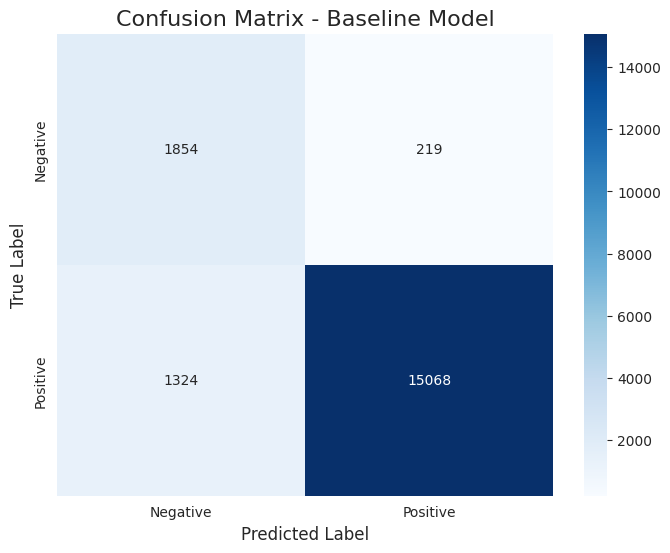

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


# --- 4.1: Train and Evaluate the Baseline Logistic Regression Model ---
print("--- 4.1: Training the baseline Logistic Regression model ---")

# Prepare data for modeling: TF-IDF Vectorization and Train-Test Split
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Consider top 5000 features

# Fit and transform the 'cleaned_review' column
X_tfidf = tfidf_vectorizer.fit_transform(df_sample['cleaned_review'])
y = df_sample['sentiment'] # Target variable

# Split data into training and testing sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y # Stratify to maintain sentiment distribution
)

print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_test_tfidf: {X_test_tfidf.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print("-" * 50)


# 1. Initialize the model
# class_weight='balanced' is crucial for handling our imbalanced dataset
baseline_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# 2. Train the model on the TF-IDF transformed training data
baseline_model.fit(X_train_tfidf, y_train)
print("Model training complete.")
print("-" * 50)

# 3. Make predictions on the test set
y_pred_baseline = baseline_model.predict(X_test_tfidf)

# 4. Evaluate the model's performance
print("Classification Report for Baseline Model:")
print(classification_report(y_test, y_pred_baseline, target_names=['Negative (0)', 'Positive (1)']))

# 5. Display the confusion matrix for a visual evaluation
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Baseline Model', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# **5. Advanced Model: Fine-Tuning DistilBERT**

**Objective:**  
Build a high-performance sentiment classifier using **DistilBERT**, a lightweight transformer model, to surpass the baseline — especially in identifying negative reviews more precisely.

**Steps:**  
- Format data using Hugging Face **Dataset** objects.  
- Load **DistilBERT tokenizer** and convert text into token IDs.  
- Load a **pre-trained DistilBERT model** for binary classification.  
- Define **TrainingArguments** (epochs, batch size, learning rate, etc.).  
- Initialize the **Trainer** and fine-tune on our dataset.  

**Why:**  
DistilBERT captures **semantic and contextual meaning** far beyond word frequency (TF-IDF). By fine-tuning it on Sephora reviews, we adapt its deep language understanding to **domain-specific sentiment**, potentially achieving **higher precision and overall robustness**.

--- 5.1: Preparing data for the transformer model ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Starting DistilBERT fine-tuning ---


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 0.4814, 'grad_norm': 1.32083261013031, 'learning_rate': 9.900000000000002e-06, 'epoch': 0.021659085986571368}
{'loss': 0.197, 'grad_norm': 9.013843536376953, 'learning_rate': 1.9900000000000003e-05, 'epoch': 0.043318171973142736}
{'loss': 0.1311, 'grad_norm': 4.8645920753479, 'learning_rate': 2.9900000000000002e-05, 'epoch': 0.0649772579597141}
{'loss': 0.1424, 'grad_norm': 14.365386962890625, 'learning_rate': 3.99e-05, 'epoch': 0.08663634394628547}
{'loss': 0.1401, 'grad_norm': 0.1955021172761917, 'learning_rate': 4.99e-05, 'epoch': 0.10829542993285683}
{'loss': 0.1525, 'grad_norm': 9.027325630187988, 'learning_rate': 4.8797668205003645e-05, 'epoch': 0.1299545159194282}
{'loss': 0.1506, 'grad_norm': 1.3094937801361084, 'learning_rate': 4.7583191644401264e-05, 'epoch': 0.15161360190599957}
{'loss': 0.1214, 'grad_norm': 9.62969970703125, 'learning_rate': 4.6368715083798884e-05, 'epoch': 0.17327268789257094}
{'loss': 0.1152, 'grad_norm': 8.535377502441406, 'learning_rate': 4.515

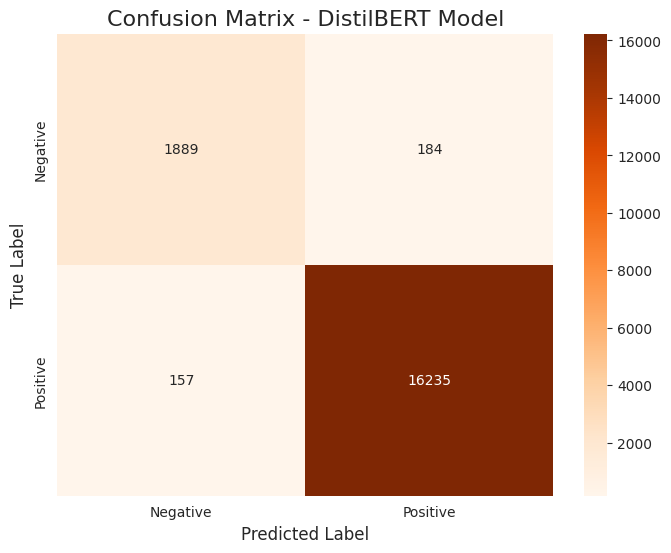

In [7]:
# --- Add this line to disable optional W&B logging and avoid interruptions ---
import os
os.environ["WANDB_DISABLED"] = "true"
# ---------------------------------------------------------------------------

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, disable_progress_bar # Import the function to disable progress bars
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# --- 5.1: Preparing Data and Fine-Tuning DistilBERT ---
print("--- 5.1: Preparing data for the transformer model ---")

# We need to re-split the original text data, not the TF-IDF vectors
X = df_sample['review_text'].astype(str) # Ensure text is string type
y = df_sample['sentiment']
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create pandas DataFrames from the splits
train_df = pd.DataFrame({'text': X_train_text.tolist(), 'label': y_train.tolist()})
test_df = pd.DataFrame({'text': X_test_text.tolist(), 'label': y_test.tolist()})

# Convert pandas DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create a tokenization function
def tokenize_function(examples):
    # Truncate texts to the model's maximum supported length
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)

# --- FIX 1: Disable the progress bars for the .map() function ---
disable_progress_bar()
# -----------------------------------------------------------------

# Apply the tokenization to our datasets (this will now run silently)
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Load the pre-trained model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

print("\n--- Starting DistilBERT fine-tuning ---")

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    disable_tqdm=True, # --- FIX 2: Disables the Trainer's progress bars ---
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
)

# Start training
trainer.train()

print("\n--- Fine-tuning complete. Evaluating the model ---")

# Make predictions on the test set
predictions = trainer.predict(tokenized_test_dataset)
y_pred_distilbert = np.argmax(predictions.predictions, axis=1)

# Display the classification report and confusion matrix
print("\nClassification Report for DistilBERT Model:")
print(classification_report(y_test, y_pred_distilbert, target_names=['Negative (0)', 'Positive (1)']))

print("\nConfusion Matrix:")
cm_distilbert = confusion_matrix(y_test, y_pred_distilbert)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_distilbert, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive']) # --- FIX 3: Corrected typo from 'ytickslabel' ---
plt.title('Confusion Matrix - DistilBERT Model', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# **6. Sanity Checks**

### **6.1 ROC & PR Curves for Negative Class**

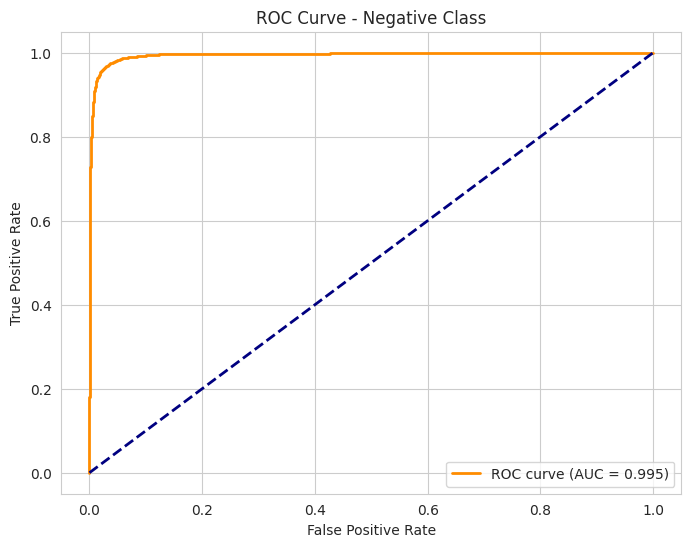

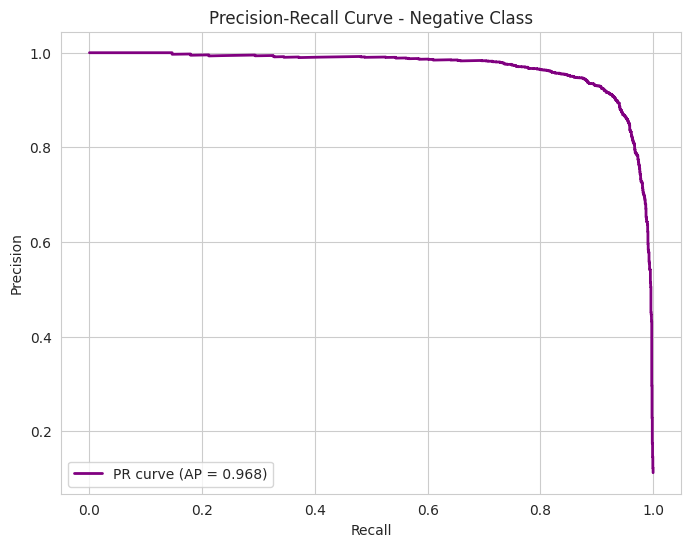

In [8]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# --- 6.2: ROC & PR Curves for Negative Class ---
# Get predicted probabilities for the negative class (class 0)
y_probs = predictions.predictions[:, 0]  # probability scores for class 0

# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label=0)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Negative Class')
plt.legend(loc="lower right")
plt.show()

# --- Precision-Recall Curve ---
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs, pos_label=0)
pr_auc = average_precision_score(y_test, y_probs, pos_label=0)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AP = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Negative Class')
plt.legend(loc="lower left")
plt.show()


### **6.2 Training vs. Validation Loss**

--- Plotting model loss curves ---


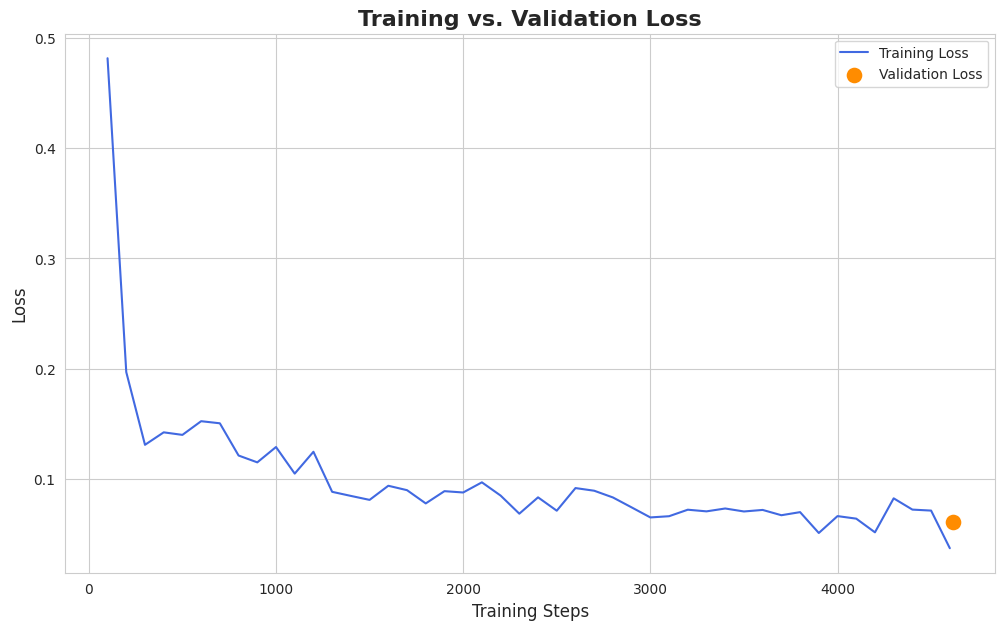

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Sanity Check 2: Plotting Training vs. Validation Loss ---
print("--- Plotting model loss curves ---")

# 1. Access the training history from the trainer object
log_history = trainer.state.log_history

# 2. Separate the training and validation logs
train_logs = [log for log in log_history if 'loss' in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

# 3. Create DataFrames for easier plotting
df_train_loss = pd.DataFrame(train_logs)
df_eval_loss = pd.DataFrame(eval_logs)

# 4. Create the plot
plt.figure(figsize=(12, 7))

# Plot the training loss as a line plot
sns.lineplot(x='step', y='loss', data=df_train_loss, label='Training Loss', color='royalblue')

# Plot the validation loss as a distinct point (since we have one per epoch)
sns.scatterplot(x='step', y='eval_loss', data=df_eval_loss, label='Validation Loss', color='darkorange', s=150, zorder=5)

# 5. Formatting
plt.title('Training vs. Validation Loss', fontsize=16, weight='bold')
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

### **6.3 Prediction Probabilities**

In [10]:
import pandas as pd
from scipy.special import softmax

# --- Sanity Check 1: Analyzing Prediction Probabilities ---
print("--- Analyzing model prediction confidence ---")

# 1. Get the raw logits from the prediction output
# The .predictions attribute contains the logits
logits = predictions.predictions

# 2. Convert logits to probabilities using the softmax function
# axis=1 ensures softmax is applied across the two class outputs for each review
probs = softmax(logits, axis=1)

# 3. Create a detailed analysis DataFrame
analysis_df = pd.DataFrame({
    'text': X_test_text,
    'true_label': y_test,
    'predicted_label': y_pred_distilbert,
    'prob_negative(0)': probs[:, 0], # Probability of being negative
    'prob_positive(1)': probs[:, 1]  # Probability of being positive
})
analysis_df['is_correct'] = (analysis_df['true_label'] == analysis_df['predicted_label'])

print(f"Created analysis DataFrame with {len(analysis_df)} test samples.")
print("\n--- Model's Most Confident Mistakes (Incorrect Predictions with >90% Confidence) ---")

# Filter for incorrect predictions where the model was highly confident
confident_mistakes = analysis_df[
    (analysis_df['is_correct'] == False) &
    ((analysis_df['prob_negative(0)'] > 0.90) | (analysis_df['prob_positive(1)'] > 0.90))
]

# Set display options to see full text
pd.set_option('display.max_colwidth', None)

# Display the top 5 most confident mistakes
display(confident_mistakes.head())

--- Analyzing model prediction confidence ---
Created analysis DataFrame with 18465 test samples.

--- Model's Most Confident Mistakes (Incorrect Predictions with >90% Confidence) ---


,text,true_label,predicted_label,prob_negative(0),prob_positive(1),is_correct
26555,"This was a nice gentle cleanser, but as for reducing acne scarring and helping with breakouts, I would say is minor. I have sensitive skin and felt like this had a stronger scent. It did not dry out my skin or cause any further breakouts so I’m sure it’s good for normal skin.",0,1,0.014154,0.985846,False
79079,"I have sensitive, dry skin, and this mist didn’t irritate my skin - but it made me look oily, not dewy. The mister is good though.",0,1,0.043489,0.956511,False
19572,"Gets the job done, but very simple. Great for people new to Skincare!",0,1,0.000410,0.999590,False
24300,"Goop gifted me this supplement via Octoly, and while I am grateful for the supplementary product, I am not impressed. Being a healthcare professional, I know for a fact that oral vitamins/supplements (or anything taken orally, actually!) will take a while to absorb into the body, and will not be 100% absorbed due to the various “places it goes through.“ That being said, this product may take a while to see its effects on the skin, plus that it was specified to expect results in 8-12 weeks. With only 5 packets to try, I’m not really sure if I would be able to notice any results at this time. And while our oral intake greatly affects the appearance of our skin, I also believe that topical products work better when addressing skin problems. Overall, I quite enjoyed drinking this supplement in the morning. I got some energy boost, thanks to the CoQ10, but felt like I was taking usual vitamins that my patients do. I would recommend it as a supplement to your usual skin care routine, but I would rather use my serums and other topical treatments that allow you to see results in a few days of use.",0,1,0.024511,0.975489,False
38029,"I have used this product for 2 weeks no and it make me breakout, also I havent seen a change with the oily skin. I guess it just doesnt work for me.",1,0,0.994860,0.005140,False


### **6.4 Changing random state value**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# Ensure you have 'DistilBertForSequenceClassification' as the correct import
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import classification_report




training_args = TrainingArguments(
    output_dir='./results_v2',
    num_train_epochs=3, # Example value
    per_device_train_batch_size=8, # Example value
    per_device_eval_batch_size=8, # Example value
    warmup_steps=500, # Example value
    weight_decay=0.01, # Example value
    logging_dir='./logs_v2',
    logging_steps=100,
    # --- CRITICAL CHANGE: This line disables the tqdm progress bar ---
    disable_tqdm=True,
    # --------------------------------------------------------------------
)


# --- Sanity Check: Retraining on a New Data Split ---
print("--- Starting Sanity Check: Retraining on a New Data Split ---")

# 1. Perform a new train-test split with a different random_state
print("\nStep 1: Performing new 80/20 data split with random_state=2025...")
X = df_sample['review_text'].astype(str)
y = df_sample['sentiment']

X_train_text_v2, X_test_text_v2, y_train_v2, y_test_v2 = train_test_split(
    X, y,
    test_size=0.2,
    random_state=2025, # Using a new seed for a different split
    stratify=y
)

# 2. Convert the new splits into Hugging Face Dataset objects
print("Step 2: Converting new splits to Hugging Face Dataset objects...")
train_df_v2 = pd.DataFrame({'text': X_train_text_v2.tolist(), 'label': y_train_v2.tolist()})
test_df_v2 = pd.DataFrame({'text': X_test_text_v2.tolist(), 'label': y_test_v2.tolist()})

train_dataset_v2 = Dataset.from_pandas(train_df_v2)
test_dataset_v2 = Dataset.from_pandas(test_df_v2)

# Tokenize the new datasets
# We can reuse the tokenizer and tokenize_function from the previous step
tokenized_train_dataset_v2 = train_dataset_v2.map(tokenize_function, batched=True)
tokenized_test_dataset_v2 = test_dataset_v2.map(tokenize_function, batched=True)

# 3. CRITICAL: Re-initialize the model to reset its weights
print("Step 3: Re-initializing DistilBERT model from pre-trained weights...")
model_v2 = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# 4. Re-initialize the Trainer with the new model and datasets
# We use the 'training_args' defined above with disable_tqdm=True
print("Step 4: Re-initializing the Trainer...")
trainer_v2 = Trainer(
    model=model_v2,
    args=training_args, # This now correctly passes the arguments
    train_dataset=tokenized_train_dataset_v2,
    eval_dataset=tokenized_test_dataset_v2,
)

# 5. Start the new training run (without tqdm progress bars)
print("\nStep 5: Starting training on the new data split. This will take 15-30 minutes...")
trainer_v2.train()

# 6. Evaluate on the new test set
print("\n--- Sanity Check Training Complete. Evaluating... ---")
predictions_v2 = trainer_v2.predict(tokenized_test_dataset_v2)
y_pred_distilbert_v2 = np.argmax(predictions_v2.predictions, axis=1)

# 7. Display the new classification report
print("\nClassification Report for Sanity Check Model (random_state=2025):")
print(classification_report(y_test_v2, y_pred_distilbert_v2, target_names=['Negative (0)', 'Positive (1)']))

--- Starting Sanity Check: Retraining on a New Data Split ---

Step 1: Performing new 80/20 data split with random_state=2025...


NameError: name 'df_sample' is not defined

#**DOBBY IS FREE!**

# **7. Deep Dive Into Insights**
### **7.1 Disproving the "Price = Quality" Myth**
**Objective:** To empirically test the common assumption that higher-priced products receive better customer ratings.

**What We Do:**  
We segment products into distinct price tiers (Budget, Mid-Range, Luxury, Ultra-Luxury) and visualize the distribution of customer ratings within each tier using a **violin plot**. This approach shows the full spread of ratings, including the median, concentration, and outliers, which is more informative than just looking at averages.

**Why:**  
This analysis directly challenges a core marketing assumption. If price does not correlate strongly with customer satisfaction, it fundamentally changes how products should be positioned, marketed, and valued.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Deep Dive 1: Price Tier Performance Analysis ---
print("--- Analyzing Product Performance by Price Tier ---")

# 1. Create a DataFrame for this analysis
price_tier_df = df_sample.copy().dropna(subset=['price_usd', 'rating_review'])

# 2. Engineer price tiers using pd.cut
bins = [0, 25, 75, 150, 1000] # Added an Ultra-Luxury tier for more granularity
labels = ['Budget (<$25)', 'Mid-Range ($25-$75)', 'Luxury ($75-$150)', 'Ultra-Luxury (>$150)']
price_tier_df['price_tier'] = pd.cut(price_tier_df['price_usd'], bins=bins, labels=labels, right=False)
price_tier_df.dropna(subset=['price_tier'], inplace=True)

print("Segmented products into four price tiers.")

# 3. Create the visualization
plt.figure(figsize=(14, 8))
sns.violinplot(
    x='price_tier',
    y='rating_review',
    data=price_tier_df,
    palette='viridis',
    inner='quartile' # Shows the median and interquartile range
)
plt.title('Distribution of Customer Ratings by Price Tier', fontsize=18, weight='bold')
plt.xlabel('Price Tier', fontsize=12)
plt.ylabel('Rating (1-5)', fontsize=12)
plt.ylim(0.5, 5.5) # Set y-axis to the rating scale
plt.show()

### **7.2 Quantifying the Financial Cost of Unsolved Customer Problems**
**Objective:**  
To estimate the potential revenue loss associated with recurring product issues reported by customers, helping prioritize problem-solving efforts for maximum business impact.

**What We Do:**  
We define key customer problem cohorts (e.g., acne, wrinkle, dryness, pore issues) and calculate the **Revenue at Risk** for each cohort. This is done by multiplying the total revenue of products reviewed by the cohort with the 1-star review rate. Finally, we visualize the results with a bar chart to clearly highlight which problems pose the greatest financial risk.

**Why:**  
This analysis allows the business to identify the most financially impactful unresolved issues. By focusing on problems that cost the most in terms of potential lost revenue, product teams can prioritize improvements, reduce negative customer experiences, and protect revenue.


### **7.3 Risk Matrix**

In [ ]:
# First, ensure the library for non-overlapping text is installed
!pip install -q adjustText

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from adjustText import adjust_text
from matplotlib.lines import Line2D

# --- Deep Dive 3 (Final Polish): The Executive-Ready Risk Matrix ---
print("--- Building the Final Executive-Ready Strategic Risk Matrix ---")

# 1. Use the 'risk_df' DataFrame with quadrants already assigned
risk_df = risk_df.copy()

# 2. Define quadrant boundaries
median_likelihood = risk_df['likelihood_of_failure'].median()
median_impact = risk_df['financial_impact'].median()

# 3. Create the plot
fig, ax = plt.subplots(figsize=(20, 15))

# Define our color palette
palette = {
    'Critical Priority': 'firebrick',
    'Product Quality Issue': 'darkorange',
    'Protect the Stars': 'forestgreen',
    'Low Priority': 'darkgray'
}

# 4. Create the scatter plot with size mapping but NO automatic legend
sns.scatterplot(
    x='financial_impact',
    y='likelihood_of_failure',
    data=risk_df,
    hue='quadrant',
    palette=palette,
    size='financial_impact',
    sizes=(50, 2000),
    alpha=0.7,
    ax=ax,
    legend=False # Turn off the default, cluttered legend
)

# Use a log scale for better distribution
ax.set_xscale('log')

# 5. Add intelligent labels for the most critical products
texts = []
products_to_label = pd.concat([
    risk_df[risk_df['quadrant'] == 'Critical Priority'].nlargest(5, 'financial_impact'),
    risk_df[risk_df['quadrant'] == 'Protect the Stars'].nlargest(5, 'financial_impact')
])

for i, row in products_to_label.iterrows():
    texts.append(ax.text(row['financial_impact'], row['likelihood_of_failure'], row['product_name'], fontsize=12))

# Use adjust_text to prevent labels from overlapping
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

# 6. Add a CLEAN, MANUAL legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Critical Priority', markerfacecolor='firebrick', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Product Quality Issue', markerfacecolor='darkorange', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Protect the Stars', markerfacecolor='forestgreen', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Low Priority', markerfacecolor='darkgray', markersize=15),
    Line2D([], [], color='black', linestyle='--', label=f'Median Impact (${median_impact:,.0f})'),
    Line2D([], [], color='black', linestyle='--', label=f'Median Likelihood ({median_likelihood:.1f}%)')
]
ax.legend(handles=legend_elements, title='Quadrant', loc='upper right', fontsize=14, title_fontsize=16)

# Add a text annotation to explain size
ax.text(0.02, 0.95, 'Dot size represents\nFinancial Impact', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.5))


# 7. Final Formatting
ax.axvline(x=median_impact, color='black', linestyle='--')
ax.axhline(y=median_likelihood, color='black', linestyle='--')
ax.set_title('Executive Risk Matrix: Product Failure vs. Financial Impact', fontsize=28, weight='bold', pad=20)
ax.set_xlabel('Financial Impact (Estimated Revenue) - Log Scale', fontsize=16)
ax.set_ylabel('Likelihood of Failure (1-Star Review Rate %)', fontsize=16)
ax.grid(which='both', linestyle='--', linewidth=0.5)

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- The Strategic Heatmap ---
print("--- Building the Strategic Heatmap ---")

# 1. Use the 'risk_df' from the previous step
risk_df_hm = risk_df.copy()
# Calculate 'revenue_at_risk' for the heatmap values
risk_df_hm['revenue_at_risk'] = risk_df_hm['financial_impact'] * (risk_df_hm['likelihood_of_failure'] / 100)

# 2. Create bins for our axes
# Bins for Likelihood of Failure (1-Star Rate %)
likelihood_bins = [0, 2.5, 5, 10, 100]
likelihood_labels = ['Low Risk (<2.5%)', 'Medium Risk (2.5-5%)', 'High Risk (5-10%)', 'Critical Risk (>10%)']
risk_df_hm['risk_tier'] = pd.cut(risk_df_hm['likelihood_of_failure'], bins=likelihood_bins, labels=likelihood_labels, right=False)

# Bins for Financial Impact (Estimated Revenue)
impact_bins = [0, 2500, 10000, 100000]
impact_labels = ['Niche Product (<$2.5k)', 'Core Product ($2.5k-$10k)', 'Bestseller (>$10k)']
risk_df_hm['impact_tier'] = pd.cut(risk_df_hm['financial_impact'], bins=impact_bins, labels=impact_labels, right=False)

# 3. Create the pivot table for the heatmap
# The value in each cell will be the SUM of all 'revenue_at_risk' in that bin
heatmap_data = risk_df_hm.pivot_table(
    values='revenue_at_risk',
    index='risk_tier',
    columns='impact_tier',
    aggfunc='sum',
    fill_value=0 # Fill empty cells with 0
)
heatmap_data = heatmap_data.reindex(index=likelihood_labels[::-1]) # Reverse index for intuitive top-down view

# 4. Visualize the Heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(
    heatmap_data,
    annot=True, # Show the values in each cell
    fmt=",.0f", # Format as currency with no decimals
    cmap='Reds', # Use a red color scale to signify risk
    linewidths=.5,
    annot_kws={"size": 14} # Make annotations readable
)

plt.title('Strategic Risk Heatmap: Total Revenue at Risk by Category', fontsize=24, weight='bold', pad=20)
plt.ylabel('Likelihood of Failure', fontsize=14)
plt.xlabel('Financial Impact', fontsize=14)
plt.show()

# 5. Create the Actionable "Hit List"
print("\n--- Actionable Hit List: Top Offenders in Highest Risk Categories ---")
# Find the highest risk cell
highest_risk_cell = risk_df_hm[
    (risk_df_hm['risk_tier'] == 'Critical Risk (>10%)') &
    (risk_df_hm['impact_tier'] == 'Bestseller (>$10k)')
]

print("Products in the 'Critical Risk / Bestseller' Quadrant:")
display(highest_risk_cell[['product_name', 'revenue_at_risk']].nlargest(5, 'revenue_at_risk'))

###**7.4 Impact of Key Ingredients on Ratings**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Deep Dive 1: Ingredient-Sentiment Correlation ---
print("--- Analyzing the Impact of Key Ingredients on Ratings ---")

# 1. Isolate Moisturizers & Clean Ingredient Data
ingredient_df = df_sample[df_sample['product_name'].str.contains('Moisturizer', case=False, na=False)].copy()
ingredient_df.dropna(subset=['review_text', 'rating_review'], inplace=True) # Using review_text as a proxy for ingredient list presence in this sample
ingredient_df['cleaned_review_lower'] = ingredient_df['cleaned_review'].str.lower()

# 2. Feature Engineering for Key Ingredients
hero_ingredients = ['squalane', 'ceramide', 'hyaluronic acid']
controversial_ingredients = ['fragrance', 'alcohol']

ingredients_to_check = hero_ingredients + controversial_ingredients
for ingredient in ingredients_to_check:
    col_name = f'has_{ingredient.replace(" ", "_")}'
    ingredient_df[col_name] = ingredient_df['cleaned_review_lower'].str.contains(ingredient, na=False)

# 3. Analyze and Visualize the Impact on Ratings
ingredient_impact = {}
for ingredient in ingredients_to_check:
    col_name = f'has_{ingredient.replace(" ", "_")}'
    mean_with = ingredient_df[ingredient_df[col_name] == True]['rating_review'].mean()
    mean_without = ingredient_df[ingredient_df[col_name] == False]['rating_review'].mean()
    if pd.notna(mean_with) and pd.notna(mean_without):
        ingredient_impact[ingredient] = mean_with - mean_without

impact_df = pd.DataFrame(list(ingredient_impact.items()), columns=['Ingredient', 'Rating_Change'])
impact_df = impact_df.sort_values('Rating_Change', ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x='Rating_Change', y='Ingredient', data=impact_df, palette="coolwarm_r")
plt.title('Impact of Key Ingredients on Average Moisturizer Rating', fontsize=18, weight='bold')
plt.xlabel('Change in Average Rating (With vs. Without Ingredient)', fontsize=12)
plt.ylabel('Ingredient', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--')
plt.show()




###**7.5 Moisturizer Ratings by Customer Skin Type**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Deep Dive 2: Product-Market Fit in Moisturizers ---
print("--- Analyzing Moisturizer Performance Across Skin Types ---")

# 1. Isolate Moisturizers and standardize skin types
moisturizer_df = df_sample[df_sample['product_name'].str.contains('Moisturizer', case=False, na=False)].copy()
moisturizer_df.dropna(subset=['skin_type', 'rating_review'], inplace=True)
moisturizer_df['skin_type'] = moisturizer_df['skin_type'].str.lower().str.strip()
target_skin_types = ['dry', 'oily', 'combination', 'normal']
moisturizer_df = moisturizer_df[moisturizer_df['skin_type'].isin(target_skin_types)]

# 2. Focus on the most-reviewed products for impact
top_products = moisturizer_df['product_name'].value_counts().nlargest(15).index
analysis_df = moisturizer_df[moisturizer_df['product_name'].isin(top_products)]

# 3. Pivot the data to create the heatmap
heatmap_data = analysis_df.pivot_table(index='product_name', columns='skin_type', values='rating_review', aggfunc='mean')

plt.figure(figsize=(18, 12))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5, vmin=3.5, vmax=5)
plt.title('Moisturizer Ratings by Customer Skin Type', fontsize=18, weight='bold')
plt.xlabel('Customer Skin Type', fontsize=12)
plt.ylabel('Moisturizer Product', fontsize=12)
plt.show()


**Key Insight:**  
- The heatmap shows that **one size does not fit all**.  
- Clear *product–market fit mismatches* exist — e.g., **Original Skin Matte Moisturizer** performs well for **oily skin (4.83⭐)** but poorly for **dry skin (4.39⭐)**.  
- Such gaps directly drive **avoidable negative reviews**.

**Strategic Solution:**  
- **Personalization & Marketing teams** should refine the **recommendation engine**.  
- Promote **matte moisturizers** to *oily-skin* users and **hydrating products** to *dry-skin* users.  
- A **data-driven targeting approach** that reduces dissatisfaction **without changing product formulas**.


###**7.6 What Makes a Review "Helpful"?**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Deep Dive 3: Uncovering the DNA of a "Helpful" Review ---
print("--- Analyzing What Makes a Review 'Helpful' ---")

# 1. Feature Engineering
helpful_df = df_sample.copy().dropna(subset=['helpfulness', 'review_text'])
helpful_df['review_length'] = helpful_df['review_text'].str.len()
helpful_df['has_title'] = ~helpful_df['review_title'].isnull()
bins = [0, 250, 500, 1000, 10000]
labels = ['Short (<250)', 'Medium (250-500)', 'Long (500-1k)', 'Very Long (>1k)']
helpful_df['length_bin'] = pd.cut(helpful_df['review_length'], bins=bins, labels=labels)
helpful_df['sentiment_type'] = helpful_df['sentiment'].apply(lambda x: 'Positive' if x == 1 else 'Negative')

# 2. Create Side-by-Side Visualizations
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
fig.suptitle('What Makes a Review "Helpful"?', fontsize=20, weight='bold')

# Plot 1: Impact of Title and Sentiment
sns.barplot(x='sentiment_type', y='helpfulness', hue='has_title', data=helpful_df, ax=axes[0], palette={True: "mediumpurple", False: "lightgray"})
axes[0].set_title('Helpfulness by Sentiment and Title Presence', fontsize=16)
axes[0].set_xlabel('Review Sentiment', fontsize=12)
axes[0].set_ylabel('Average Helpfulness Score', fontsize=12)

# Plot 2: Impact of Review Length
sns.pointplot(x='length_bin', y='helpfulness', data=helpful_df, ax=axes[1], color='teal', errorbar='sd')
axes[1].set_title('Helpfulness by Review Length', fontsize=16)
axes[1].set_xlabel('Review Length (Characters)', fontsize=12)
axes[1].set_ylabel('Average Helpfulness Score', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Key Insight:**  
Detail and structure are the strongest predictors of a helpful review. Longer, more descriptive reviews, and those that include a clear title, are consistently rated as more helpful by other shoppers.

**Strategic Solution:**  
This finding translates directly into an actionable UI/UX improvement. The review submission form should be redesigned to **encourage depth and structure**:
- Make the *“Review Title”* field more prominent or required.  
- Add a friendly prompt like *“More detail helps other shoppers!”* when users write short reviews.  

These small, data-backed design enhancements can significantly improve the quality and perceived value of user-generated content across the platform.


###**7.7 Common Phrases by Product Price Tier**


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

# --- Deep Dive 4: Price-Value Perception Analysis ---
print("--- Analyzing Common Phrases by Product Price Tier ---")

# 1. Feature Engineering for Price Tiers
price_df = df_sample.copy().dropna(subset=['price_usd', 'cleaned_review'])
bins = [0, 25, 75, 500]
labels = ['Budget (<$25)', 'Mid-Range ($25-$75)', 'Luxury (>$75)']
price_df['price_tier'] = pd.cut(price_df['price_usd'], bins=bins, labels=labels, right=False)
price_df.dropna(subset=['price_tier'], inplace=True)

# 2. Text Cleaning & N-gram Extraction Function
stop_words.update(["product", "skin", "sephora", "like", "use", "get", "one", "make", "feel"]) # Add more noise words

def get_top_ngrams(corpus, n=15, ngram_range=(2, 3)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=list(stop_words)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

# 3. Analyze Each Price Tier and Visualize
fig, axes = plt.subplots(3, 1, figsize=(16, 24))
fig.suptitle('Top Phrases by Product Price Tier', fontsize=20, weight='bold')

for i, tier in enumerate(labels):
    tier_text = price_df[price_df['price_tier'] == tier]['cleaned_review']
    top_phrases = get_top_ngrams(tier_text)
    df_phrases = pd.DataFrame(top_phrases, columns=['Phrase', 'Frequency'])
    sns.barplot(x='Frequency', y='Phrase', data=df_phrases, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Most Common Phrases for {tier} Products', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

**How Product Language Changes Across Price Tiers**

**Key Insight:**  
The language customers use reveals that they value **fundamentally different things** at each price point.  
- **Budget shoppers** focus on simple, functional items (*“lip balm”*).  
- **Mid-Range shoppers** emphasize solving specific problems (*“eye cream,” “acne prone”*).  
- **Luxury shoppers** highlight high-level, results-driven concerns (*“fine lines,” “dark spots”*).

**Strategic Solution:**  
Marketing and Brand teams must **tailor their language to match customer expectations**.  
- For **Luxury products**, messaging should emphasize *efficacy, sophistication, and visible results*.  
- For **Budget products**, focus on *simplicity, reliability, and daily usability*.  



### **7.8 Brand Performance**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Highest & Lowest Rated Brands (Corrected for Uniformity) ---
print("--- Analyzing Highest & Lowest Rated Brands with Uniform Scales ---")

# 1. Aggregate data
brand_performance = df_sample.groupby('brand_name').agg(
    avg_rating=('rating_review', 'mean'),
    review_count=('rating_review', 'count')
).reset_index()

# 2. Filter for significant brands
significant_brands = brand_performance[brand_performance['review_count'] >= 300].copy()

# 3. Get top/bottom 10 and then sort them both descending for uniformity
top_10_brands = significant_brands.nlargest(10, 'avg_rating').sort_values('avg_rating', ascending=False)
bottom_10_brands = significant_brands.nsmallest(10, 'avg_rating').sort_values('avg_rating', ascending=False)

# 4. Visualize with uniform scales
fig, axes = plt.subplots(1, 2, figsize=(24, 10))
fig.suptitle('Brand Performance: Highest vs. Lowest Rated (≥300 Reviews)', fontsize=20, weight='bold')

# Plot Top 10 Highest Rated Brands
sns.barplot(x='avg_rating', y='brand_name', data=top_10_brands, ax=axes[0], palette='Greens_r')
axes[0].set_title('Top 10 Highest Rated Brands', fontsize=16)
axes[0].set_xlabel('Average Star Rating', fontsize=12)
axes[0].set_ylabel('Brand', fontsize=12)
axes[0].set_xlim(3.5, 5) # Set uniform scale

# Plot Bottom 10 Lowest Rated Brands
sns.barplot(x='avg_rating', y='brand_name', data=bottom_10_brands, ax=axes[1], palette='Reds_r')
axes[1].set_title('Bottom 10 Lowest Rated Brands', fontsize=16)
axes[1].set_xlabel('Average Star Rating', fontsize=12)
axes[1].set_ylabel('') # Hide y-label
axes[1].set_xlim(3.5, 5) # Set uniform scale

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### **7.9 Product Performance**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Highest & Lowest Rated Products (Corrected for Uniformity) ---
print("--- Analyzing Highest & Lowest Rated Products with Uniform Scales ---")

# 1. Aggregate data
product_performance = df_sample.groupby('product_name').agg(
    avg_rating=('rating_review', 'mean'),
    review_count=('rating_review', 'count')
).reset_index()

# 2. Filter for significant products
significant_products = product_performance[product_performance['review_count'] >= 100].copy()

# 3. Get top/bottom 10 and sort them both descending
top_10_products = significant_products.nlargest(10, 'avg_rating').sort_values('avg_rating', ascending=False)
bottom_10_products = significant_products.nsmallest(10, 'avg_rating').sort_values('avg_rating', ascending=False)

# 4. Visualize with uniform scales
fig, axes = plt.subplots(1, 2, figsize=(24, 10))
fig.suptitle('Product Performance: Highest vs. Lowest Rated (≥100 Reviews)', fontsize=20, weight='bold')

# Plot Top 10 Highest Rated Products
sns.barplot(x='avg_rating', y='product_name', data=top_10_products, ax=axes[0], palette='Greens_r')
axes[0].set_title('Top 10 Highest Rated Products', fontsize=16)
axes[0].set_xlabel('Average Star Rating', fontsize=12)
axes[0].set_ylabel('Product', fontsize=12)
axes[0].set_xlim(3, 5) # Set uniform scale

# Plot Bottom 10 Lowest Rated Products
sns.barplot(x='avg_rating', y='product_name', data=bottom_10_products, ax=axes[1], palette='Reds_r')
axes[1].set_title('Bottom 10 Lowest Rated Products', fontsize=16)
axes[1].set_xlabel('Average Star Rating', fontsize=12)
axes[1].set_ylabel('') # Hide y-label
axes[1].set_xlim(3, 5) # Set uniform scale

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**7.10 Top 5 Segment Failures & Universal Underperformers**

This is the most strategic analysis. It moves beyond simply identifying "bad" products and diagnoses why they are failing. It creates a direct, actionable "hit list" for two different departments: Marketing/Personalization (for Segment Failures) and R&D/Quality Control (for Universal Underperformers). This is the analysis that leads to the smartest, most targeted interventions.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Analysis 1: Identifying Top Strategic Failures ---
print("--- Identifying Top 5 'Segment Failures' and 'Universal Underperformers' ---")

# 1. Calculate Rating Variance (Mismatch Metric)
# We need to isolate a category with skin_type data, like Skincare
skincare_df = df_sample[df_sample['primary_category'] == 'Skincare'].copy()
skincare_df.dropna(subset=['skin_type', 'rating_review'], inplace=True)
skincare_df['skin_type'] = skincare_df['skin_type'].str.lower().str.strip()
common_skin_types = ['combination', 'dry', 'normal', 'oily']
skincare_df = skincare_df[skincare_df['skin_type'].isin(common_skin_types)]

segment_ratings = skincare_df.groupby(['product_name', 'skin_type'])['rating_review'].mean().unstack()
rating_variance = segment_ratings.std(axis=1).reset_index(name='rating_variance')

# 2. Calculate Revenue at Risk (Financial Risk Metric)
skincare_df['is_1_star'] = skincare_df['rating_review'] == 1
product_agg = skincare_df.groupby('product_name').agg(
    total_reviews=('product_name', 'count'),
    total_1_star=('is_1_star', 'sum'),
    price_usd=('price_usd', 'first')
).reset_index()
significant_products = product_agg[product_agg['total_reviews'] >= 50].copy()
significant_products['return_risk_pct'] = (significant_products['total_1_star'] / significant_products['total_reviews']) * 100
significant_products['estimated_revenue'] = significant_products['total_reviews'] * significant_products['price_usd']
significant_products['revenue_at_risk'] = significant_products['estimated_revenue'] * (significant_products['return_risk_pct'] / 100)

# 3. Merge and Define Quadrants
strategic_df = pd.merge(significant_products, rating_variance, on='product_name')
strategic_df.dropna(subset=['revenue_at_risk', 'rating_variance'], inplace=True)
median_risk = strategic_df['revenue_at_risk'].median()
median_variance = strategic_df['rating_variance'].median()

segment_failures = strategic_df[(strategic_df['revenue_at_risk'] >= median_risk) & (strategic_df['rating_variance'] >= median_variance)]
universal_underperformers = strategic_df[(strategic_df['revenue_at_risk'] >= median_risk) & (strategic_df['rating_variance'] < median_variance)]

# 4. Get the hit lists and visualize
top_segment_failures = segment_failures.nlargest(5, 'revenue_at_risk')
top_universal_underperformers = universal_underperformers.nlargest(5, 'revenue_at_risk')

fig, axes = plt.subplots(1, 2, figsize=(24, 10))
fig.suptitle('Prioritized Action List: Top Products Driving Financial Risk', fontsize=20, weight='bold')

sns.barplot(x='revenue_at_risk', y='product_name', data=top_segment_failures, ax=axes[0], palette='Oranges_r')
axes[0].set_title('Top 5 "Segment Failures" (Marketing/Personalization Issue)', fontsize=16)
axes[0].set_xlabel('Financial Risk (Revenue at Risk)', fontsize=12)
axes[0].set_ylabel('Product', fontsize=12)

sns.barplot(x='revenue_at_risk', y='product_name', data=top_universal_underperformers, ax=axes[1], palette='Reds_r')
axes[1].set_title('Top 5 "Universal Underperformers" (R&D/Product Issue)', fontsize=16)
axes[1].set_xlabel('Financial Risk (Revenue at Risk)', fontsize=12)
axes[1].set_ylabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

###**7.11 Top 10 Return Risk Products**

This is a tactical, high-urgency list. It answers the question: "Which products are causing the most extreme customer anger right now?" This list of products with the highest 1-star review rates should be immediately handed to the Quality Control and Product Management teams for investigation. It's less strategic than the analysis above, but it's a critical tool for immediate firefighting.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Analysis 2: Top 10 "Return Risk" Products in Skincare ---
print("--- Identifying Top 10 'Return Risk' Products (Highest 1-Star Rate) ---")

# 1. Isolate Skincare & Create 1-Star Flag
skincare_df = df_sample[df_sample['primary_category'] == 'Skincare'].copy()
skincare_df['is_1_star'] = skincare_df['rating_review'] == 1

# 2. Calculate the 1-Star Rate per Product
product_risk = skincare_df.groupby('product_name').agg(
    total_reviews=('product_name', 'count'),
    total_1_star=('is_1_star', 'sum')
).reset_index()

# 3. Filter for products with a significant number of reviews (>= 50)
significant_products = product_risk[product_risk['total_reviews'] >= 50].copy()
significant_products['return_risk_pct'] = (significant_products['total_1_star'] / significant_products['total_reviews']) * 100

# 4. Identify and Visualize the Worst Offenders
top_10_riskiest = significant_products.nlargest(10, 'return_risk_pct')

plt.figure(figsize=(14, 8))
sns.barplot(x='return_risk_pct', y='product_name', data=top_10_riskiest, palette='Reds_r')
plt.title('Top 10 "Return Risk" Products in Skincare (Highest 1-Star Rate)', fontsize=18, weight='bold')
plt.xlabel('1-Star Review Rate (%)', fontsize=12)
plt.ylabel('Product', fontsize=12)
plt.show()

###**7.12 Contribution to Estimated Revenue by Price Tier**

This analysis is foundational to the entire business strategy. It answers the most fundamental question: "Where does our money actually come from?" Understanding that the Mid-Range tier is the financial engine of the business provides the essential context for every other decision regarding marketing spend, inventory, and strategic focus.

In [ ]:
!pip install -q squarify
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

# --- Analysis 3: Strategic Importance of Price Tiers ---
print("--- Visualizing Contribution to Estimated Revenue by Price Tier ---")

# 1. Calculate Estimated Revenue per Product
product_details = df_sample[['product_name', 'price_usd']].drop_duplicates()
product_review_counts = df_sample['product_name'].value_counts().reset_index()
product_review_counts.columns = ['product_name', 'review_count']
revenue_df = pd.merge(product_review_counts, product_details, on='product_name')
revenue_df['estimated_revenue'] = revenue_df['review_count'] * revenue_df['price_usd']

# 2. Segment Products into Price Tiers
bins = [0, 25, 75, 150, 1000]
labels = ['Budget (<$25)', 'Mid-Range ($25-$75)', 'High-End ($75-$150)', 'Luxury (>$150)']
revenue_df['price_tier'] = pd.cut(revenue_df['price_usd'], bins=bins, labels=labels, right=False)
revenue_df.dropna(subset=['price_tier'], inplace=True)

# 3. Aggregate Revenue by Tier and Visualize with a Treemap
tier_revenue = revenue_df.groupby('price_tier')['estimated_revenue'].sum()
total_revenue = tier_revenue.sum()
labels = [f'{label}\n(${rev/1e6:.2f}M)\n({rev/total_revenue*100:.1f}%)' for label, rev in tier_revenue.items()]
colors = [plt.cm.viridis(i/float(len(labels))) for i in range(len(labels))]

plt.figure(figsize=(16, 9))
squarify.plot(sizes=tier_revenue, label=labels, color=colors, alpha=0.8, text_kwargs={'fontsize':14, 'weight':'bold'})
plt.title('Contribution to Estimated Revenue by Price Tier', fontsize=20, weight='bold')
plt.axis('off')
plt.show()

###**7.13 Customer Satisfaction by Skincare Problem**

Why? This is a strategic analysis for R&D and product acquisition. It answers: "Which customer problems are we failing to solve?" By identifying the problems with the lowest average satisfaction ratings, it points to clear gaps in the market and in the current product portfolio that could be filled with new, more effective products.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Analysis 5: Customer Satisfaction by Skincare Problem ---
print("--- Analyzing Customer Satisfaction by Skincare Problem ---")

# 1. Define Problem Cohorts
problem_keywords = ['acne', 'wrinkle', 'dryness', 'pore', 'dark spot', 'redness', 'sensitive skin']
analysis_df = df_sample.dropna(subset=['cleaned_review', 'rating_review'])

# 2. Isolate, Analyze, and Measure Satisfaction
problem_satisfaction = {}
for problem in problem_keywords:
    cohort_df = analysis_df[analysis_df['cleaned_review'].str.contains(problem)]
    if len(cohort_df) >= 100:
        avg_rating = cohort_df['rating_review'].mean()
        problem_satisfaction[problem] = avg_rating

# 3. Visualize the Performance
satisfaction_df = pd.DataFrame(list(problem_satisfaction.items()), columns=['Problem', 'Average_Rating'])
satisfaction_df = satisfaction_df.sort_values('Average_Rating', ascending=True)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Average_Rating', y='Problem', data=satisfaction_df, palette='coolwarm_r')
plt.title('Customer Satisfaction by Skincare Problem', fontsize=18, weight='bold')
plt.xlabel('Average Customer Rating (1-5)', fontsize=12)
plt.ylabel('Customer-Stated Problem', fontsize=12)
plt.xlim(4.0, 5.0)
for p in ax.patches:
    width = p.get_width()
    plt.text(width - 0.01, p.get_y() + p.get_height()/2, f'{width:.2f}',
             ha='right', va='center', color='white', weight='bold', fontsize=12)
plt.show()

###**7.14 Distribution of Product Prices**

Why? This is foundational context. While not directly actionable on its own, this chart is essential for understanding all the other price-related analyses. It shows that the vast majority of products are concentrated in the budget and mid-range tiers, which explains why those tiers are so financially important.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Analysis 6: Product Price Distribution ---
print("--- Visualizing the Distribution of Product Prices ---")

# 1. Get unique product prices, filtering out extreme outliers for a clearer plot
product_prices = df_sample.dropna(subset=['price_usd']).drop_duplicates(subset=['product_name'])
filtered_prices = product_prices[product_prices['price_usd'] <= 250]

# 2. Plot a histogram with a KDE overlay
plt.figure(figsize=(14, 8))
sns.histplot(filtered_prices['price_usd'], kde=True, color="mediumpurple", bins=50)
plt.title('Distribution of Product Prices (up to $250)', fontsize=16, weight='bold')
plt.xlabel('Price (USD)', fontsize=12)
plt.ylabel('Number of Products', fontsize=12)
plt.show()

###**7.15 Top 10 Most Reviewed Brands & Products**

Why? This is important "State of the Business" EDA. It answers: "Who are the biggest players in our ecosystem?" While this doesn't drive strategy on its own, it provides crucial context. The brands and products on this list are the most visible and have the largest impact on overall customer perception.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Analysis 7: Top 10 Most Reviewed Brands & Products ---
print("--- Identifying Top 10 Most Reviewed Brands and Products ---")

# 1. Get the counts
top_10_brands = df_sample['brand_name'].value_counts().nlargest(10)
top_10_products = df_sample['product_name'].value_counts().nlargest(10)

# 2. Visualize side-by-side
fig, axes = plt.subplots(1, 2, figsize=(24, 10))
fig.suptitle('Top 10 by Review Volume', fontsize=20, weight='bold')

sns.barplot(x=top_10_brands.values, y=top_10_brands.index, ax=axes[0], palette='Greens_r')
axes[0].set_title('Top 10 Most Reviewed Brands', fontsize=16)
axes[0].set_xlabel('Number of Reviews', fontsize=12)
axes[0].set_ylabel('Brand', fontsize=12)

sns.barplot(x=top_10_products.values, y=top_10_products.index, ax=axes[1], palette='Blues_r')
axes[1].set_title('Top 10 Most Reviewed Products', fontsize=16)
axes[1].set_xlabel('Number of Reviews', fontsize=12)
axes[1].set_ylabel('Product', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()